In [29]:
import sys
import os
import shutil
import platform
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pyemu
import flopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;

In [30]:
# specify a temporary folder; we will gather all our model and executable files here first
# this is to ensure we don't mess up our original model files
tmp_d = os.path.join('freyberg_mf6')

# get the necessary executables; OS agnostic
bin_dir = os.path.join('..','..','bin')

if "window" in platform.platform().lower():
    exe_files = [f for f in os.listdir(bin_dir) if f.endswith('exe')]
else:
    exe_files = [f for f in os.listdir(bin_dir) if not f.endswith('exe')]

# remove existing folder if it already exists
if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)

# make the folder
os.mkdir(tmp_d)

# copy executables across
for exe_file in exe_files:
    shutil.copy2(os.path.join(bin_dir, exe_file),os.path.join(tmp_d,exe_file))

Let's copy the original model folder into a new working directory, just to ensure we don't mess up the base files.

In [31]:
# folder containing original model files
org_d = os.path.join('..', '..', 'models', 'freyberg_mf6')

# copy files across to the temp folder
for f in os.listdir(org_d):
    shutil.copy2(os.path.join(org_d,f), os.path.join(tmp_d,f))

In [32]:
# load simulation
sim = flopy.mf6.MFSimulation.load(sim_ws=tmp_d, verbosity_level=0)
# load flow model
gwf = sim.get_model()

# run the model once to make sure it works
sim.run_simulation()

(True, [])

### 2. Spatial Reference
Now we can instantiate a `SpatialReference`. This will later be passed to `PstFrom` to assist with spatially locating parameters (e.g. pilot points and/or cell-by-cell parameters).

In [33]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(tmp_d, "freyberg6.nam"),
        delr=gwf.dis.delr.array, delc=gwf.dis.delc.array)

   could not remove start_datetime


### 3. Instantiate PstFrom

Now we can start to construct the PEST(++) interface by instantiating a `PstFrom` class instance. There are a few things that we need to specify up front:

 - the folder in which we currently have model files (e.g. `tmp_d`). PstFrom will copy all the files from this directory into a new "template" folder.
 - **template folder**: this is a folder in which the PEST dataset will be constructed. This folder/dataset will form the template for subsequent deployment of PEST(++). It is **not** where PEST(++) will be run.
 - **longnames**: for backwards compatibility with PEST and PEST_HP (i.e. non-PEST++ versions), which have upper limits to parameter/obsveration names (PEST++ does not). Setting this value to False is only recommended if required. 
 - Whether the model is `zero based` or not.
 - (optional) the **spatial reference**, as previously discussed. This is only requried if using `pyEMU` to define parameter spatial correlation. Alternatively, you can define these yourself or use utilities available in the PEST-suite. 



In [34]:
# specify a template directory (i.e. the PstFrom working folder)
template_ws = os.path.join("freyberg6_template")

# instantiate PstFrom
pf = pyemu.utils.PstFrom(original_d=tmp_d, # where the model is stored
                            new_d=template_ws, # the PEST template folder
                            remove_existing=True, # ensures a clean start
                            longnames=True, # set False if using PEST/PEST_HP
                            spatial_reference=sr, #the spatial reference we generated earlier
                            zero_based=False, # does the MODEL use zero based indices? For example, MODFLOW does NOT
                            start_datetime="1-1-2018") # required when specifying temporal correlation between parameters

2022-03-02 16:15:27.927408 starting: opening PstFrom.log for logging
2022-03-02 16:15:27.927408 starting PstFrom process
2022-03-02 16:15:27.928373 starting: setting up dirs
2022-03-02 16:15:27.928373 starting: removing existing new_d 'freyberg6_template'
2022-03-02 16:15:28.250841 finished: removing existing new_d 'freyberg6_template' took: 0:00:00.322468
2022-03-02 16:15:28.250841 starting: copying original_d 'freyberg_mf6' to new_d 'freyberg6_template'
2022-03-02 16:15:31.572660 finished: copying original_d 'freyberg_mf6' to new_d 'freyberg6_template' took: 0:00:03.321819
2022-03-02 16:15:31.573658 finished: setting up dirs took: 0:00:03.645285


In [35]:
# check the output csv file names
for i in gwf.obs:
    print(i.output.obs_names)

['sfr.csv']
['heads.csv']


In [36]:
# read the measured head values
hds_meas = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"heads.meas.csv"),
                    index_col=0)

# re-write the model output .csv file with the measured values
hds_meas.to_csv(os.path.join(template_ws,"heads.csv"))

In [37]:
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)

hds_df = pf.add_observations("heads.csv", # the model output file to read
                            insfile="heads.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hds") #prefix to all observation names; choose something logical and easy o find. We use it later on to select obsevrations

2022-03-02 16:15:31.672425 starting: adding observations from output file heads.csv
2022-03-02 16:15:31.672425 starting: adding observations from tabular output file '['heads.csv']'
2022-03-02 16:15:31.673656 starting: reading list-style file: freyberg6_template\heads.csv
2022-03-02 16:15:31.674650 finished: reading list-style file: freyberg6_template\heads.csv took: 0:00:00.000994
2022-03-02 16:15:31.675646 starting: building insfile for tabular output file heads.csv
2022-03-02 16:15:31.681631 finished: building insfile for tabular output file heads.csv took: 0:00:00.005985
2022-03-02 16:15:31.681631 starting: adding observation from instruction file 'freyberg6_template\heads.csv.ins'
2022-03-02 16:15:31.693600 finished: adding observation from instruction file 'freyberg6_template\heads.csv.ins' took: 0:00:00.011969
2022-03-02 16:15:31.694597 finished: adding observations from tabular output file '['heads.csv']' took: 0:00:00.022172


In [38]:
hds_df

,obsnme,obsval,weight,obgnme
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450633,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441733,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375639,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323119,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
...,...,...,...,...
oname:hds_otype:lst_usecol:trgw_2_9_1_time:640.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:640.0,35.021809,1.0,oname:hds_otype:lst_usecol:trgw_2_9_1
oname:hds_otype:lst_usecol:trgw_2_9_1_time:671.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:671.0,34.986489,1.0,oname:hds_otype:lst_usecol:trgw_2_9_1
oname:hds_otype:lst_usecol:trgw_2_9_1_time:701.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:701.0,34.947490,1.0,oname:hds_otype:lst_usecol:trgw_2_9_1
oname:hds_otype:lst_usecol:trgw_2_9_1_time:732.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:732.0,35.006586,1.0,oname:hds_otype:lst_usecol:trgw_2_9_1


Blimey, wasn't that easy? Automatically assimilating thousands of observations into a PEST dataset becomes a breeze!

Let's quickly do the same thing for the SFR observations.

In [39]:
# read the measured  values
meas = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"sfr.meas.csv"),
                    index_col=0)
# re-write the model output .csv file with the measured values
meas.to_csv(os.path.join(template_ws,"sfr.csv"))

df = pd.read_csv(os.path.join(template_ws, "sfr.csv"), index_col=0)
# add the observations to pf
sfr_df = pf.add_observations("sfr.csv", # the model output file to read
                            insfile="sfr.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="sfr") #prefix to all observation names

2022-03-02 16:15:31.792352 starting: adding observations from output file sfr.csv
2022-03-02 16:15:31.793337 starting: adding observations from tabular output file '['sfr.csv']'
2022-03-02 16:15:31.793337 starting: reading list-style file: freyberg6_template\sfr.csv
2022-03-02 16:15:31.795330 finished: reading list-style file: freyberg6_template\sfr.csv took: 0:00:00.001993
2022-03-02 16:15:31.795330 starting: building insfile for tabular output file sfr.csv
2022-03-02 16:15:31.800349 finished: building insfile for tabular output file sfr.csv took: 0:00:00.005019
2022-03-02 16:15:31.800349 starting: adding observation from instruction file 'freyberg6_template\sfr.csv.ins'
2022-03-02 16:15:31.807346 finished: adding observation from instruction file 'freyberg6_template\sfr.csv.ins' took: 0:00:00.006997
2022-03-02 16:15:31.808298 finished: adding observations from tabular output file '['sfr.csv']' took: 0:00:00.014961


<AxesSubplot:xlabel='distance', ylabel='$\\gamma$'>

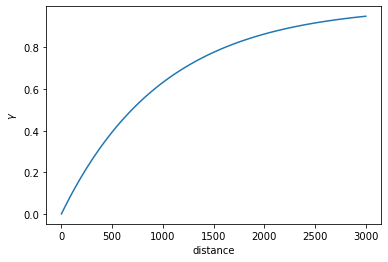

In [40]:
# exponential variogram for spatially varying parameters
v_space = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=1000, # range of correlation; length units of the model. In our case 'meters'
                                    anisotropy=1.0, #name says it all
                                    bearing=0.0 #angle in degrees East of North corresponding to anisotropy ellipse
                                    )

# geostatistical structure for spatially varying parameters
grid_gs = pyemu.geostats.GeoStruct(variograms=v_space, transform='log') 

# plot the gs if you like:
grid_gs.plot()

In [41]:
# exponential variogram for time varying parameters
v_time = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=60, # range of correlation; length time units (days)
                                    anisotropy=1.0, #do not change for 1-D time
                                    bearing=0.0 #do not change for 1-D time
                                    )

# geostatistical structure for time varying parameters
temporal_gs = pyemu.geostats.GeoStruct(variograms=v_time, transform='none') 

#### 5.3. Add Parameters

Let's start by adding parameters of hydraulic properties that vary in space (but not time) and which are housed in array-type files (e.g. Kh, Kv, Ss, Sy). We will start by demonstrating step-by-step for Kh.

First, find all the external array files that contain Kh values. In our case, these are the files with "npf_k_" in the file name. As you can see below, there is one file for each model layer. 

In [42]:
tag = "npf_k_"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
print(files)

['freyberg6.npf_k_layer1.txt', 'freyberg6.npf_k_layer2.txt', 'freyberg6.npf_k_layer3.txt']


In [43]:
# as IDOMIAN is the same in all layers, we can use any layer
ib = gwf.dis.idomain.get_data(layer=0)

In [44]:
for f in files:
    # constant (coarse) scale parameters
    pf.add_parameters(f,
                        zone_array=ib,
                        par_type="constant",
                        par_style='direct',
                        par_name_base='hk',
                        pargp='hk',
                        lower_bound=0.01, upper_bound=500)

2022-03-02 16:15:32.046555 starting: adding constant type d style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-02 16:15:32.047562 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-02 16:15:32.048559 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.000997
2022-03-02 16:15:32.048559 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-02 16:15:32.049543 starting: writing array-style template file 'freyberg6_template\freyberg6.npf_k_layer1.txt.tpl'
2022-03-02 16:15:32.049543 starting: writing template file freyberg6_template\freyberg6.npf_k_layer1.txt.tpl for ['hk_inst:0']
2022-03-02 16:15:32.057492 finished: writing template file freyberg6_template\freyberg6.npf_k_layer1.txt.tpl for ['hk_inst:0'] took: 0:00:00.007949
2022-03-02 16:15:32.058004 starting: writing array-based template file 'freyberg6_template\freyberg6.npf_k_layer1.txt.tpl'
2022-03-02 16:15:32.058004 saving zone array

In [46]:
# for Recharge; 
tag = "rch_recharge"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
for f in files:
   
    # multiplier that includes temporal correlation
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    
    # add the constant parameters (with temporal correlation)
    pf.add_parameters(filenames=f,
                    zone_array=ib,
                    par_type="constant",
                    par_name_base=f'rch{kper+1}',
                    pargp="rch",
                    lower_bound=0.5, upper_bound=1.5)

2022-03-02 16:15:32.174238 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt']
2022-03-02 16:15:32.175271 WARNING: 0) Inconsistency between geostruct transform and partrans.
2022-03-02 16:15:32.175271 WARNING: 1) Setting geostruct transform to {transform}
2022-03-02 16:15:32.175271 WARNING: -) Better to pass an appropriately transformed geostruct
2022-03-02 16:15:32.175271 starting: loading array freyberg6_template\freyberg6.rch_recharge_1.txt
2022-03-02 16:15:32.176230 finished: loading array freyberg6_template\freyberg6.rch_recharge_1.txt took: 0:00:00.000959
2022-03-02 16:15:32.176230 loaded array 'freyberg_mf6\freyberg6.rch_recharge_1.txt' of shape (40, 20)
2022-03-02 16:15:32.178229 starting: writing array-style template file 'freyberg6_template\rch1_inst0_constant.csv.tpl'
2022-03-02 16:15:32.178229 starting: writing template file freyberg6_template\rch1_inst0_constant.csv.tpl for ['rch1_inst:0']
2022-03-02 16:15:32.184208 finished: writ

In [47]:
pf.mod_sys_cmds.append("mf6") #do this only once
pf.mod_sys_cmds

['mf6']

In [48]:
pst = pf.build_pst()


noptmax:0, npar_adj:28, nnz_obs:725
2022-03-02 16:15:32.905829 forward_run line:pyemu.os_utils.run(r'mf6')



In [49]:
obs = pst.observation_data

Hmm, that's alot of observations. And remember, alot of these pertain to the "prediction" period. We definitly do not want those to have an influence on history-matching.

To be on the safe side, let's assign a weight of zero to all observations. Then, we will assign weights to specific observations that we wish to include as history-matching targets.

In [50]:
# preemptive avoidance of sillyness
obs['weight'] = 0
obs.head()

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450633,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441733,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375639,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323119,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0


So, if we want to select observations from the `heads.csv` file, and that have a time < than 367, we can just use `Pandas` .loc:

In [51]:
obs.head()

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450633,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441733,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375639,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323119,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0


In [52]:
obs.loc[(obs['oname']=='hds') & (obs['time'].astype(float) <= 367)]

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450633,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441733,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375639,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323119,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:hds_otype:lst_usecol:trgw_2_9_1_time:32.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:32.0,35.138463,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,32.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:336.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:336.0,35.137710,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,336.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:367.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:367.0,35.381095,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,367.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:61.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:61.0,35.323660,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,61.0


OK, so now let's use this to assign weights to each observation type. We will set weights to the inverse of the standard deviation of our measurment uncertainty.

Let's say that stdevs for:
 - head measurements are is 0.1m,
 - head time an vertical differences 0.01m
 - SFR direct and time-differnces will be 10% of the measured value

In [53]:
# direct head measurments
obs.loc[(obs['oname']=='hds') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.1
# head time differences
obs.loc[(obs['oname']=='hdstd') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.01
# head vertical differences
obs.loc[(obs['oname']=='hdsvd') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.01

In [54]:
# SFR direct measurments
weights = 1 / abs(0.1 * obs.loc[(obs['oname']=='sfr') & (obs['time'].astype(float) <= 367), 'obsval'].values)
obs.loc[(obs['oname']=='sfr') & (obs['time'].astype(float) <= 367), 'weight'] = weights

# SFR time-difference measurments; deal with the first observation value that is == 0
weights = 1 / abs(0.1 * obs.loc[(obs['oname']=='sfrtd') & (obs['time'].astype(float) <= 367) &  (obs['obsval'] !=0) , 'obsval'].values)
obs.loc[(obs['oname']=='sfrtd') & (obs['time'].astype(float) <= 367) &  (obs['obsval'] !=0), 'weight'] = weights

Make sure to re-**write** the PEST control file. But beware, if you re-**build** the `Pst`, all these changes will be lost.

In [55]:
pst.write(os.path.join(template_ws, 'freyberg_mf6.pst'))

noptmax:0, npar_adj:28, nnz_obs:377


So that was pretty epic. We now have a (very) high-dimensional PEST interface ready to roll. 

If you inspect the folder, you will see PEST control file and all the necessary instruction and template files. Because we have >10k parameters, version 2 of the PEST control file was written by default. 

Shall we check that it works? Let's run PEST once (i.e. with NOPTMAX=0). Now, by default, noptmax is set to zero. But just to check:

In [56]:
pst.control_data.noptmax

0

OK, so when we run PEST it will call the model once and then stop. If the next cell is sucessfull, then eveything is working. Check the folder, you should see PEST output files. (We will go into these and how to process PEST outcomes in subsequent tutorials).

In [57]:
pyemu.os_utils.run('pestpp-glm freyberg_mf6.pst', cwd=template_ws)

In [59]:
pyemu.utils

Object `pyemu.utils._get_tpl_or_ins_df` not found.
